# Question 4 - Employee Performance

## Define Question

Northwind employs a sales team to facilitate global trade. Profitability is dependent on the quality of the sales team. There are two obvious ways to measure employee performance: average gross revenue and total number of orders in a given timeframe. In this document, I compare employee performance based on average annual gross revenue and total orders.


> Is there a statistically significant difference in the average annual gross revenue between employees?

## State Hypothesis

**Null Hypothesis**: There is no difference in the average gross revenue per order between employees. 

> $H_{o}: \mu_1 = \mu_2 = ... = \mu_n$ 

**Alternative Hypothesis**: There is a statistically significant difference in the average gross revenue per order between employees. 

> $H_{a}: \mu_1 \neq \mu_i$ 

**Significance Level**: 95% confidence level

> $\alpha = .05$

## Methodology

I load my data and calculate gross revenue for each order in the dataframe. After examining my data, I remove the outliers that would skew my results. I then run an ANOVA test and a Tukey test to determine which employees bring in the highest average gross revenue.

## Import Libraries and Connect to Data Source

In [1]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols

#Personal stats functions
from hypothesis_testing import bootstrap, boot_sampling_dist, remove_outliers, Cohen_d, create_sampling_distribution

#For Tukey Test
import itertools
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [2]:
conn = sqlite3.connect('northwind_small.sqlite')
c = conn.cursor()

## Obtain Data

In [3]:
# Visualize summary statistics for employees
emp_query = """SELECT printf('%s %s', e.FirstName, e.LastName) AS Name, 
                    e.Title, asdf.EmployeeID, asdf.TotalOrders, asdf.GrossRevenue, 
                    (asdf.GrossRevenue/asdf.TotalQuantity) AS AveGrossRevPerOrder
                FROM (
                    SELECT 
                        e.ID AS EmployeeID, o.OrderDate,
                        SUM(od.Quantity) as TotalQuantity,
                        SUM(od.Quantity*od.UnitPrice*(1-od.Discount)) as GrossRevenue,
                        Count(Distinct OrderId) as TotalOrders
                    FROM Employee e
                    JOIN [Order] o
                    ON e.ID == o.EmployeeId
                    JOIN OrderDetail od 
                    ON o.Id == od.OrderId
                    GROUP BY e.ID
                    ) asdf
                JOIN Employee e 
                ON EmployeeID == e.ID
            """
employee_orders_df = pd.read_sql(emp_query, conn)
employee_orders_df

,Name,Title,EmployeeID,TotalOrders,GrossRevenue,AveGrossRevPerOrder
0,Nancy Davolio,Sales Representative,1,123,192107.6045,24.591347
1,Andrew Fuller,"Vice President, Sales",2,96,166537.7550,27.504171
2,Janet Leverling,Sales Representative,3,127,202812.8430,25.829450
3,Margaret Peacock,Sales Representative,4,156,232890.8460,23.769223
4,Steven Buchanan,Sales Manager,5,42,68792.2825,22.658855
5,Michael Suyama,Sales Representative,6,67,73913.1295,20.956374
6,Robert King,Sales Representative,7,72,124568.2350,26.765843
7,Laura Callahan,Inside Sales Coordinator,8,104,126862.2775,21.454808
8,Anne Dodsworth,Sales Representative,9,43,77308.0665,28.954332


In [4]:
# Create dataframe to work with
query = """SELECT o.EmployeeId, printf('%s %s', e.FirstName, e.LastName) AS Name, 
            e.Title, od.OrderId, 
            SUM(od.Quantity) AS OrderQuantity,
            sum(UnitPrice * Quantity * (1-Discount)) AS GrossRevenue
            FROM 
            OrderDetail od 
            JOIN 'Order' o ON o.Id=od.OrderId
            JOIN Employee e ON e.Id=o.EmployeeId
            GROUP BY od.OrderId
            ORDER BY o.EmployeeId
            """
emp_df = pd.read_sql(query,conn)
display(emp_df.head())
emp_df.EmployeeId.value_counts()

,EmployeeId,Name,Title,OrderId,OrderQuantity,GrossRevenue
0,1,Nancy Davolio,Sales Representative,10258,121,1614.88
1,1,Nancy Davolio,Sales Representative,10270,55,1376.00
2,1,Nancy Davolio,Sales Representative,10275,18,291.84
3,1,Nancy Davolio,Sales Representative,10285,121,1743.36
4,1,Nancy Davolio,Sales Representative,10292,20,1296.00


4    156
3    127
1    123
8    104
2     96
7     72
6     67
9     43
5     42
Name: EmployeeId, dtype: int64

## Scrub Data

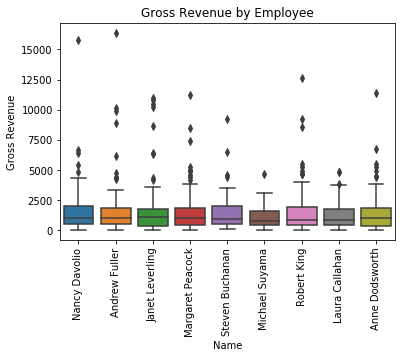

In [5]:
# Visualize mean gross revenue by employee with boxplots
sns.boxplot(x='Name', y='GrossRevenue', 
            data=emp_df)
plt.title('Gross Revenue by Employee')
plt.xlabel('Name');
plt.ylabel('Gross Revenue')
plt.xticks(rotation='vertical')
plt.show()

Clearly there are some outliers to deal with.

In [6]:
# Remove outliers from Gross Revenue
emp_new_df = remove_outliers(emp_df, "GrossRevenue")
emp_new_df.EmployeeId.value_counts()

4    148
3    120
1    118
8    102
2     91
6     67
7     66
5     40
9     38
Name: EmployeeId, dtype: int64

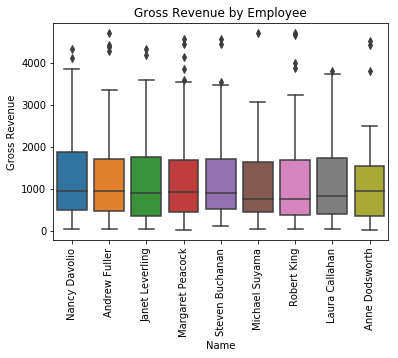

In [7]:
# Visualize mean gross revenue by employee without outliers with boxplots
sns.boxplot(x='Name', y='GrossRevenue', 
            data=emp_new_df)
plt.title('Gross Revenue by Employee')
plt.xlabel('Name');
plt.ylabel('Gross Revenue')
plt.xticks(rotation='vertical')
plt.show()

## Hypothesis Testing

Now that the outliers have been removed, I can begin my hypothesis testing. I want to compare all employees against each other. I use an **ANOVA Test** to compare the mean gross revenue across all employees. 

First I need to satisfy the **normality assumption**.

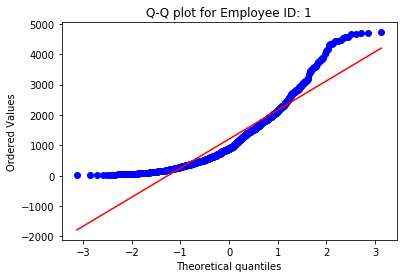

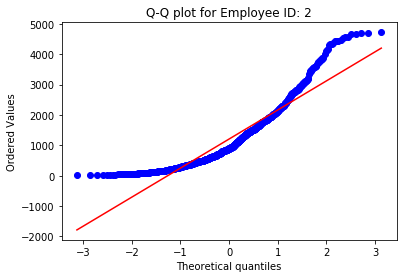

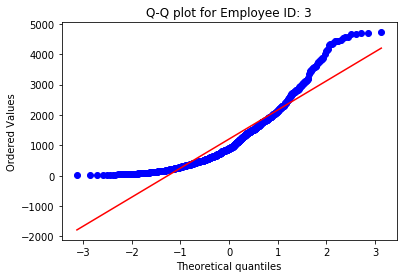

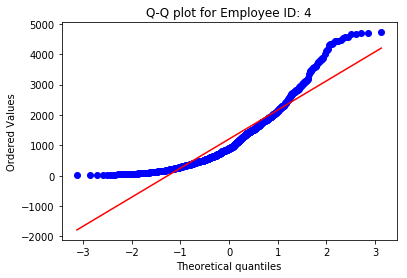

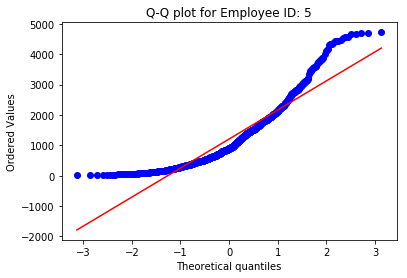

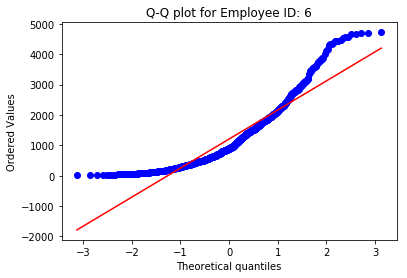

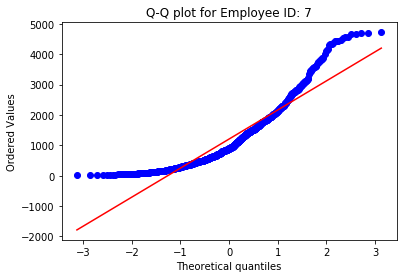

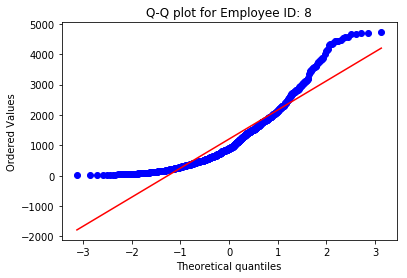

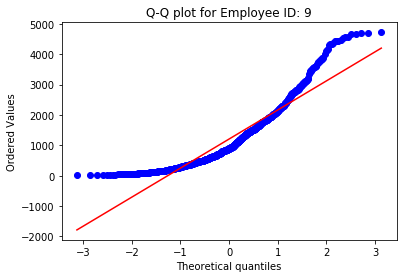

In [8]:
# Check normality for dataframe without outliers
for emp in emp_new_df.EmployeeId.unique():
    stats.probplot(emp_new_df.GrossRevenue, dist="norm", plot=plt)
    plt.title("Q-Q plot for Employee ID: {}".format(emp))
    plt.show()

### Create Sampling Distributions

The original data does not satisfy the normality assumption required for my hypothesis test. The sample sizes are also fairly small.

To solve these challenges, I use a **sampling distribution**. According to the **Central Limit Theorem**, the distribution of sample means is normal regardless of the distribution of the actual population. 

In [9]:
emp_new_df.shape

(790, 6)

In [10]:
employee_orders_df.EmployeeID.values

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
# Create the sampling distributions for every employee
emp = []
index = []
gross_rev = []

for employee in list(employee_orders_df.EmployeeID.values):
    for i in range(0,30):
        emp.append(employee)
    a1 = list(emp_new_df.GrossRevenue[(emp_new_df.EmployeeId == employee)].values)
    a2 = create_sampling_distribution(a1, 30, 30)
    index.append(a2)

for i in index:
    for e in i:
        gross_rev.append(e)
c1 = list(emp_new_df.GrossRevenue.values)
c2 = create_sampling_distribution(c1, 30, 30)


In [12]:
display(len(emp))
display(len(ord_pr))
display(len(ordp))
display(len(prices))

270

270

9

270

In [13]:
len(ordp)

9

In [21]:
# Make a DataFrame of all sampling distributions
samp_distributions = {}
samp_distributions['EmpId'] = emp
samp_distributions['Gross_Revenue'] = gross_rev
samp_distributions_df = pd.DataFrame(samp_distributions)

In [15]:
samp_distributions_df.head()

,EmpId,Gross_Revenue
0,1,1559.713167
1,1,1334.622967
2,1,1392.337750
3,1,1442.128467
4,1,1396.707750


### ANOVA Test

Now I have a dictionary of normally distributed sampling distributions for each employee. I can now run an **ANOVA Test**.

As a reminder:

**Null Hypothesis**: There is no difference in the average gross revenue per order between employees. 

> $H_{o}: \mu_1 = \mu_2 = ... = \mu_n$ 

**Alternative Hypothesis**: There is a statistically significant difference in the average gross revenue per order between employees. 

> $H_{a}: \mu_1 \neq \mu_i$ 

**Significance Level**: 95% confidence level

> $\alpha = .05$

In [16]:
samp_distributions_df.head()

,EmpId,Gross_Revenue
0,1,1559.713167
1,1,1334.622967
2,1,1392.337750
3,1,1442.128467
4,1,1396.707750


In [17]:
# Run an ANOVA test to see influentiality of salesperson choice
formula = 'Gross_Revenue ~ C(EmpId)'
lm = ols(formula, samp_distributions_df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df          F        PR(>F)
C(EmpId)  1.700370e+06    8.0  11.558058  4.809155e-14
Residual  4.799644e+06  261.0        NaN           NaN


The p value is less than alpha so I reject the null hypothesis in favor of the alternative hypothesis. Discounts have a statistically significant effect on Gross Revenue. 

### Tukey Test

Now that I know discounts have a statistically significant effect on Gross Revenue, I can investigate the different levels of discount. I use a Tukey Test to do multiple comparisons.

In [18]:
# Summary statistics for sampling distribution by employee
samp_distributions_df.Gross_Revenue.groupby(samp_distributions_df.EmpId).describe()

,count,mean,std,min,25%,50%,75%,max
EmpId,,,,,,,,
1,30.0,1336.011500,159.029433,963.664800,1217.047996,1368.068250,1446.225804,1559.713167
2,30.0,1284.502128,157.125628,1071.779000,1190.687750,1259.518333,1364.360000,1785.950167
3,30.0,1157.671315,142.215458,867.507383,1057.133454,1183.882133,1276.605908,1401.712767
4,30.0,1185.579756,157.220801,973.513500,1068.420783,1155.353542,1244.676821,1633.910500
5,30.0,1312.863375,91.488827,1101.127417,1261.215229,1304.614958,1373.548521,1458.410667
6,30.0,1123.493067,132.835775,890.983333,1060.452083,1116.102192,1203.104437,1405.363567
7,30.0,1149.407028,145.063987,892.290333,1042.192125,1139.392292,1244.123438,1447.189250
8,30.0,1144.046622,126.079945,881.061500,1073.104917,1153.767292,1221.298958,1439.753667
9,30.0,1130.556384,87.334243,925.022050,1070.156725,1132.850275,1198.584454,1257.962050


In [19]:
# Tukey Test
# Null hypothesis - the means are equal
mc = MultiComparison(samp_distributions_df.Gross_Revenue, samp_distributions_df.EmpId)
result = mc.tukeyhsd()
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  1      2     -51.5094 -161.0322  58.0134  False 
  1      3    -178.3402  -287.863  -68.8174  True 
  1      4    -150.4317 -259.9545  -40.909   True 
  1      5     -23.1481 -132.6709  86.3747  False 
  1      6    -212.5184 -322.0412 -102.9956  True 
  1      7    -186.6045 -296.1273  -77.0817  True 
  1      8    -191.9649 -301.4877  -82.4421  True 
  1      9    -205.4551 -314.9779  -95.9323  True 
  2      3    -126.8308 -236.3536  -17.308   True 
  2      4     -98.9224 -208.4452  10.6004  False 
  2      5     28.3612   -81.1615  137.884  False 
  2      6    -161.0091 -270.5318  -51.4863  True 
  2      7    -135.0951 -244.6179  -25.5723  True 
  2      8    -140.4555 -249.9783  -30.9327  True 
  2      9    -153.9457 -263.4685  -44.423   True 
  3      4     27.9084   -81.6143  137.4312 False 
  3      5     155.1921  45.669

In [23]:
employee_ids = [1,2,3,4,5,6,7,8,9]
employee_combinations = itertools.combinations(employee_ids, 2)

In [26]:
# T-test for quantity average sales revenue per order from each region
employee_sales_combo_df = pd.DataFrame(columns = ['Employee 1','Employee 2','p-value',
                                                      'Reject Null?', 'Employee 1 Sales Mean', 'Employee 2 Sales Mean',
                                                      'Difference of Means', 'Cohens d'])

for combo in employee_combinations:
    
    samp1_control = samp_distributions_df[samp_distributions_df['EmpId']==combo[0]]['Gross_Revenue']
    samp2_experimental = samp_distributions_df[samp_distributions_df['EmpId']==combo[1]]['Gross_Revenue']
    
    s1mean = samp_distributions_df[samp_distributions_df['EmpId']==combo[0]]['Gross_Revenue'].mean()
    s2mean = samp_distributions_df[samp_distributions_df['EmpId']==combo[1]]['Gross_Revenue'].mean()
    
    t_stat, p_val = stats.ttest_ind(samp1_control, samp2_experimental)
    diff_mean = round(samp1_control.mean() - samp2_experimental.mean(),2)
    effect_size_cohen = round(Cohen_d(samp1_control, samp2_experimental),3)
    
    p_val = p_val / 2 # for one tailed test
    
    employee_sales_combo_df = employee_sales_combo_df.append({'Employee 1' : combo[0], 'Employee 2': combo[1], 
                                                 'p-value': p_val, 'Reject Null?': "Yes, Reject" if p_val < 0.05 else "No, Fail to Reject",
                                                           'Employee 1 Sales Mean': s1mean, 'Employee 2 Sales Mean': s2mean,
                                                 'Difference of Means': diff_mean, 'Cohens d': effect_size_cohen}, ignore_index=True)

In [27]:
employee_sales_combo_df.head()

,Employee 1,Employee 2,p-value,Reject Null?,Employee 1 Sales Mean,Employee 2 Sales Mean,Difference of Means,Cohens d
0,1,3,9.217349e-05,"Yes, Reject",1309.746584,1128.821400,180.93,1.049
1,1,4,7.951793e-02,"No, Fail to Reject",1309.746584,1254.423183,55.32,0.375
2,1,5,3.539902e-01,"No, Fail to Reject",1309.746584,1324.275236,-14.53,0.099
3,1,6,4.104658e-08,"Yes, Reject",1309.746584,1088.921111,220.83,1.611
4,1,7,1.127735e-04,"Yes, Reject",1309.746584,1140.389036,169.36,1.033


In [28]:
employee_sales_combo_df[employee_sales_combo_df['Reject Null?'] == "Yes, Reject"]

,Employee 1,Employee 2,p-value,Reject Null?,Employee 1 Sales Mean,Employee 2 Sales Mean,Difference of Means,Cohens d
0,1,3,9.217349e-05,"Yes, Reject",1309.746584,1128.821400,180.93,1.049
3,1,6,4.104658e-08,"Yes, Reject",1309.746584,1088.921111,220.83,1.611
4,1,7,1.127735e-04,"Yes, Reject",1309.746584,1140.389036,169.36,1.033
5,1,8,2.732061e-04,"Yes, Reject",1309.746584,1167.815864,141.93,0.961
6,1,9,1.136939e-05,"Yes, Reject",1309.746584,1157.617524,152.13,1.210
7,2,3,4.064082e-04,"Yes, Reject",1287.349217,1128.821400,158.53,0.928
10,2,6,3.168528e-07,"Yes, Reject",1287.349217,1088.921111,198.43,1.469
11,2,7,5.272732e-04,"Yes, Reject",1287.349217,1140.389036,146.96,0.906
12,2,8,1.402529e-03,"Yes, Reject",1287.349217,1167.815864,119.53,0.820
13,2,9,9.113962e-05,"Yes, Reject",1287.349217,1157.617524,129.73,1.050


## Results

I can conclude that there is a statistically significant difference in the level of gross revenue brought in by different employees. Employees 1, 2, and 5 are the highest performing employees in terms of gross revenue. Employees 3 and 6 are the worst performing employees. 

## Recommendations

These results can be used to strategize ways to boost employee performance. Since employees 1, 2, and 5 bring in the most gross revenue, perhaps they could host a training session for the other employees to share their best practices. I have also identifed that employees 3 and 6 may require additional support and training to hone their sales skills. This analysis could also be used as a basis for employee bonuses and awards to boost employee satisfaction. 